# Projet ML Souleymane Mbaye

In [1]:
import sys
sys.path.append('./')
from src import Loss,Modules
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  


%load_ext autoreload
%autoreload 2

## 1. Test du Module Linear avec MSELoss sur la classification de chiffres de 0 à 9

In [2]:
import pickle as pkl

data = pkl.load(open('data/usps.pkl', 'rb'))
X = np.array(data['X_train'], dtype=float) # conversion de type pour une meilleure compatibilité
Y = np.array(data['Y_train'], dtype=int)
X_test = np.array(data['X_test'], dtype=float)
Y_test = np.array(data['Y_test'], dtype=int)

print(f"Sur X_train:\n  max:  {X.max()}\n  min:  {X.min()}")
print(f"Sur X_test:\n  max:  {X_test.max()}\n  min:  {X_test.min()}")

Sur X_train:
  max:  2.0
  min:  0.0
Sur X_test:
  max:  2.0
  min:  0.0


In [3]:
X /= 2
X_test /= 2

print(f"Sur X_train:\n  max:  {X.max()}\n  min:  {X.min()}")
print(f"Sur X_test:\n  max:  {X_test.max()}\n  min:  {X_test.min()}")

Sur X_train:
  max:  1.0
  min:  0.0
Sur X_test:
  max:  1.0
  min:  0.0


In [4]:
enc_lin_1 = Modules.Linear(256,100)
enc_tanh_1 = Modules.TanH()
enc_lin_2 = Modules.Linear(100,10)
enc_tanh_2 = Modules.TanH()

dec_lin_1 = Modules.Linear(10,100)
dec_tanh = Modules.TanH()
dec_lin_2 = Modules.Linear(100,256)
dec_sig = Modules.Sigmoid()

res_enc = [(enc_lin_1,dec_lin_2),(enc_tanh_1,),(enc_lin_2,dec_lin_1),(enc_tanh_2,)]
res_dec = [(dec_lin_1,enc_lin_2),(dec_tanh,),(dec_lin_2,enc_lin_1),(dec_sig,)]

loss_fn = Loss.BELoss()

enc_dec = Modules.EncDec(res_enc,res_dec)

optim = Modules.Optim(enc_dec,loss_fn,lr=1e-3)

In [5]:
l_train_loss = Modules.SGD(enc_dec,loss_fn,(X,X),batch_size=5,epochs=1_000,lr=1e-3)

X_test_dec = enc_dec.forward(X_test)
X_dec      = enc_dec.forward(X)

X_test_enc = enc_dec.encoder(X_test)
X_enc = enc_dec.encoder(X)

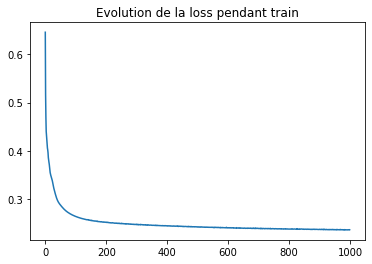

In [6]:
plt.figure()
plt.plot(np.arange(len(l_train_loss)),l_train_loss)
plt.title("Evolution de la loss pendant train")
plt.show()

## Visualisation des images reconstruites après une forte compression

### Avec les données d'entrainement (X)

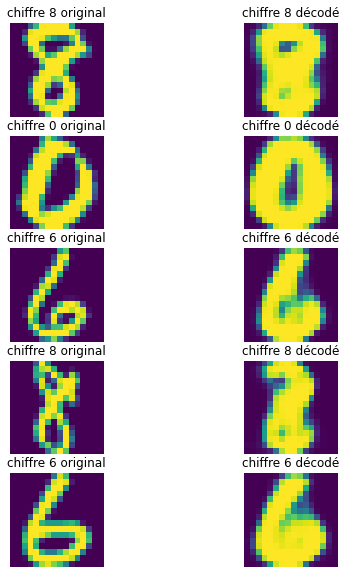

In [51]:
k = 5
indices = np.random.choice(np.arange(len(Y)),k)

fig, axes = plt.subplots(k, 2, figsize=(8, 2*k))
isub = 0
for i,ind in enumerate(indices):
  axes[i, 0].imshow(X[ind].reshape((16,16)))
  axes[i, 0].set_title(f"chiffre {Y[ind]} original")
  
  axes[i, 1].imshow(X_dec[ind].reshape((16,16)))
  axes[i, 1].set_title(f"chiffre {Y[ind]} décodé")

# Masquer les axes sur lesquels les images sont affichées
for ax in axes.flat:
  ax.axis('off')

# Ajuster les espaces entre les subplots
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

### Avec les données de test (X_test)

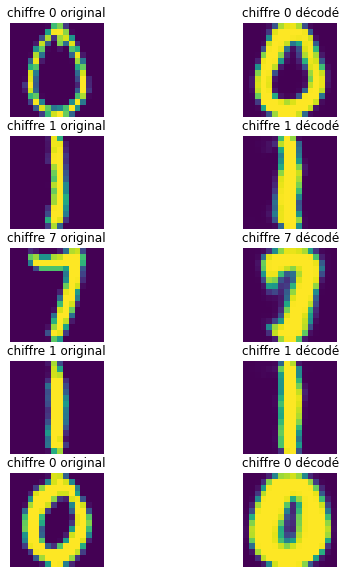

In [52]:
k = 5
indices = np.random.choice(np.arange(len(Y_test)),k)

fig, axes = plt.subplots(k, 2, figsize=(8, 2*k))
isub = 0
for i,ind in enumerate(indices):
  axes[i, 0].imshow(X_test[ind].reshape((16,16)))
  axes[i, 0].set_title(f"chiffre {Y_test[ind]} original")
  
  axes[i, 1].imshow(X_test_dec[ind].reshape((16,16)))
  axes[i, 1].set_title(f"chiffre {Y_test[ind]} décodé")

# Masquer les axes sur lesquels les images sont affichées
for ax in axes.flat:
  ax.axis('off')

# Ajuster les espaces entre les subplots
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

## Visualisation des représentations obtenues dans un espaces 2D avec t-sne

On équilibre les classes vu que kmeans et t-SNE y sont sensibles

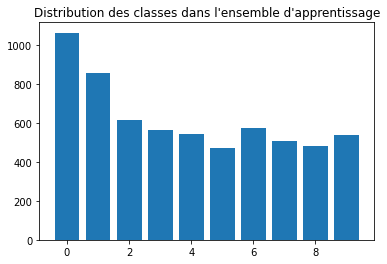

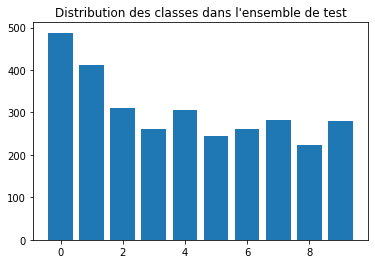

In [123]:
cli,ni = np.unique(Y,return_counts=True)
plt.bar(cli,ni)
plt.title(f"Distribution des classes dans l'ensemble d'apprentissage")
plt.show()

cli,ni = np.unique(Y_test,return_counts=True)
plt.bar(cli,ni)
plt.title(f"Distribution des classes dans l'ensemble de test")
plt.show()

In [94]:
# on équilibre les classes vu que t-SNE et kmeans y sont sensibles
inds_eq = Modules.equilibrer_classes(Y)
inds_test_eq = Modules.equilibrer_classes(Y_test)
print(f"dimension de départ: {len(Y)}\ndimension equilibrée: {len(inds_eq)}")

# equilibrage des données originales
X_eq,Y_eq = X[inds_eq],Y[inds_eq]
X_test_eq,Y_test_eq = X_test[inds_test_eq],Y_test[inds_test_eq]

# équilibrage des données encodées
X_enc_eq = X_enc[inds_eq]
X_test_enc_eq = X_test_enc[inds_test_eq]

# équilibrage des données décodées
X_dec_eq = X_dec[inds_eq]
X_test_dec_eq = X_test_dec[inds_test_eq]


dimension de départ: 6229
dimension equilibrée: 4720


### Avec les données d'entrainement (train)

#### t-SNE sur les données originales (train)

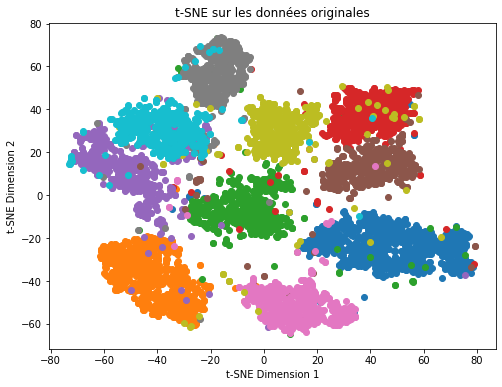

In [72]:
from sklearn.manifold import TSNE

# Appliquer t-SNE pour réduire la dimensionnalité à deux dimensions
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)

# Créer un graphique de dispersion en deux dimensions
plt.figure(figsize=(8, 6))
for cl in np.unique(Y):
  icl = Y==cl
  x_a,y_a = X_tsne[icl,0],X_tsne[icl,1]
  plt.scatter(x_a, y_a, label=cl)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE sur les données originales')

plt.show()

#### t-SNE sur l'espace latent des données (train)

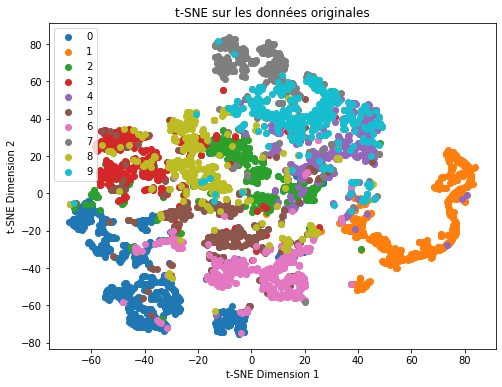

In [148]:
from sklearn.manifold import TSNE

# Appliquer t-SNE pour réduire la dimensionnalité à deux dimensions
tsne = TSNE(n_components=2, random_state=0)
X_enc_tsne = tsne.fit_transform(X_enc)

# Créer un graphique de dispersion en deux dimensions
plt.figure(figsize=(8, 6))
for cl in np.unique(Y):
  icl = Y==cl
  x_a,y_a = X_enc_tsne[icl,0],X_enc_tsne[icl,1]
  plt.scatter(x_a, y_a, label=cl)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE sur les données originales')
plt.legend()

plt.show()

### t-SNE sur les données d'entrainement reconstruites

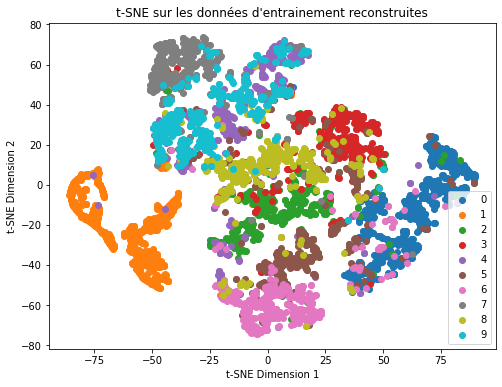

In [69]:
# Appliquer t-SNE pour réduire la dimensionnalité à deux dimensions
tsne = TSNE(n_components=2, random_state=0)
X_dec_tsne = tsne.fit_transform(X_dec)

# Créer un graphique de dispersion en deux dimensions
plt.figure(figsize=(8, 6))
for cl in np.unique(Y):
  icl = Y==cl
  x_a,y_a = X_dec_tsne[icl,0],X_dec_tsne[icl,1]
  plt.scatter(x_a, y_a, label=cl)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title("t-SNE sur les données d'entrainement reconstruites")
plt.legend()

plt.show()

### Avec les données de test

#### t-SNE sur les données de test originales

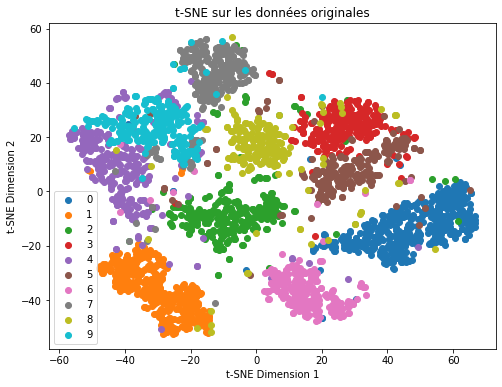

In [67]:
# Appliquer t-SNE pour réduire la dimensionnalité à deux dimensions
tsne = TSNE(n_components=2, random_state=0)
X_test_tsne = tsne.fit_transform(X_test)

# Créer un graphique de dispersion en deux dimensions
plt.figure(figsize=(8, 6))
for cl in np.unique(Y_test):
  icl = Y_test==cl
  x_a,y_a = X_test_tsne[icl,0],X_test_tsne[icl,1]
  plt.scatter(x_a, y_a, label=cl)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE sur les données originales')
plt.legend()

plt.show()

#### t-SNE sur l'espace latent des données de test

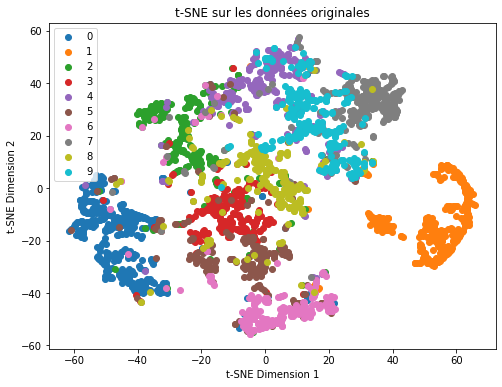

In [66]:
# Appliquer t-SNE pour réduire la dimensionnalité à deux dimensions
tsne = TSNE(n_components=2, random_state=0)
X_test_enc_tsne = tsne.fit_transform(X_test_enc)

# Créer un graphique de dispersion en deux dimensions
plt.figure(figsize=(8, 6))
for cl in np.unique(Y_test):
  icl = Y_test==cl
  x_a,y_a = X_test_enc_tsne[icl,0],X_test_enc_tsne[icl,1]
  plt.scatter(x_a, y_a, label=cl)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE sur les données originales')
plt.legend()

plt.show()

#### t-SNE sur les données de test reconstruites

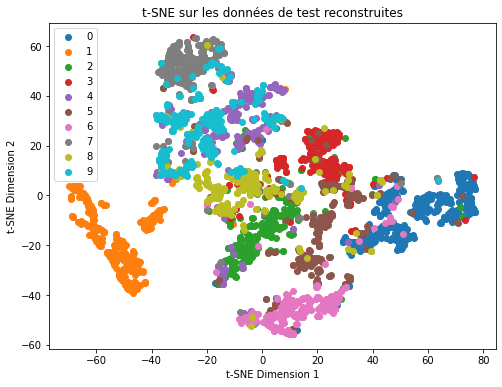

In [65]:
# Appliquer t-SNE pour réduire la dimensionnalité à deux dimensions
tsne = TSNE(n_components=2, random_state=0)
X_test_dec_tsne = tsne.fit_transform(X_test_dec)

# Créer un graphique de dispersion en deux dimensions
plt.figure(figsize=(8, 6))
for cl in np.unique(Y_test):
  icl = Y_test==cl
  x_a,y_a = X_test_dec_tsne[icl,0],X_test_dec_tsne[icl,1]
  plt.scatter(x_a, y_a, label=cl)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE sur les données de test reconstruites')
plt.legend()

plt.show()

Nous voyons que les classes sont séparées dans des clusters

## Etude du clustering induit dans l'espace latent

### Avec les données d'apprentissage (train)

In [119]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Initialiser et exécuter l'algorithme KMeans
nb_cl = len(np.unique(Y))

kmeans = KMeans(n_clusters=nb_cl, random_state=0, max_iter=1_000)
kmeans_labels = kmeans.fit_predict(X_enc_eq)


# Appliquer t-SNE pour réduire la dimensionnalité à deux dimensions
tsne = TSNE(n_components=2, random_state=0)
X_enc_eq_tsne = tsne.fit_transform(X_enc_eq)

/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


clust: 0
  cli:  0    1    2    3    4    5    6    7    8    9    
  ni :  23   1    16   26   4    309  36   1    20   1    


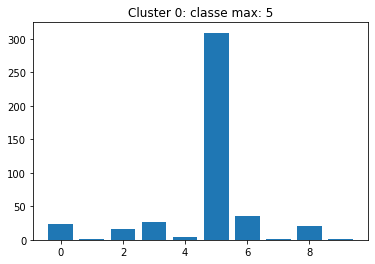

clust: 1
  cli:  0    2    3    5    7    8    9    
  ni :  2    68   9    2    370  6    34   


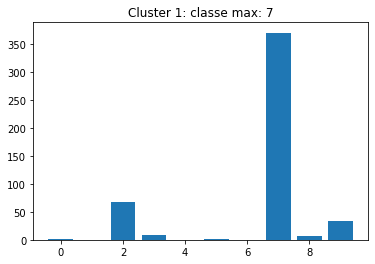

clust: 2
  cli:  1    3    4    5    6    7    8    9    
  ni :  2    3    87   7    2    59   17   319  


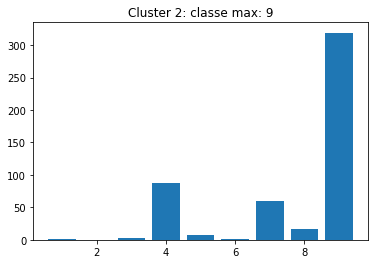

clust: 3
  cli:  0    1    2    3    4    5    6    7    8    
  ni :  58   1    5    7    6    65   376  1    6    


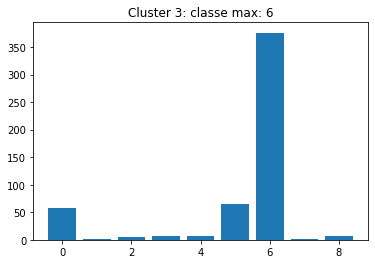

clust: 4
  cli:  0    2    3    5    7    8    9    
  ni :  9    59   382  34   1    40   1    


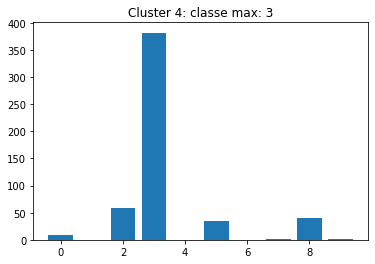

clust: 5
  cli:  0    1    2    3    4    5    6    7    8    9    
  ni :  2    1    270  4    92   19   33   14   22   1    


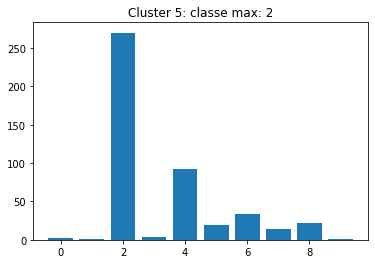

clust: 6
  cli:  0    2    3    4    5    6    8    
  ni :  377  29   2    2    20   21   14   


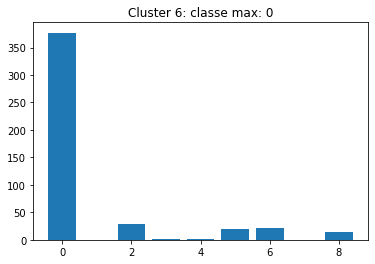

clust: 7
  cli:  1    2    3    4    5    7    8    9    
  ni :  1    6    1    263  2    18   2    87   


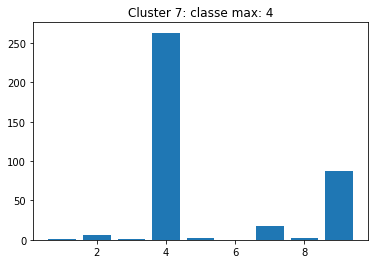

clust: 8
  cli:  0    1    2    3    4    5    6    7    8    9    
  ni :  1    2    17   37   1    14   1    2    342  5    


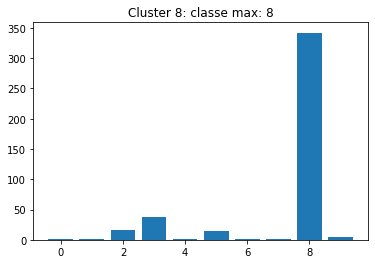

clust: 9
  cli:  1    2    3    4    6    7    8    9    
  ni :  464  2    1    17   3    6    3    24   


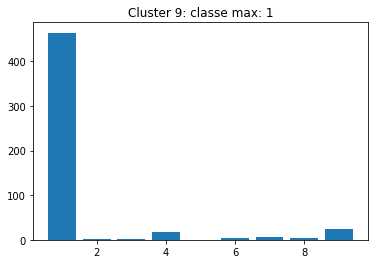

La classe maximale dans chaque cluster du kmeans:
  [5, 7, 9, 6, 3, 2, 0, 4, 8, 1]


In [120]:
labels_max = [] # classe la plus representée dans chaque cluster
ind_clust = []
for cl in np.unique(kmeans_labels):
  icl = kmeans_labels==cl
  Y_cl = Y_eq[icl]  # vrais labels des elts du clust cl
  cli,ni = np.unique(Y_cl,return_counts=True)
  cli_str,ni_str = "",""
  cli_str = cli_str.join(["{:<5}".format(str(clij)) for clij in cli])
  ni_str = ni_str.join(["{:<5}".format(str(nij)) for nij in ni])
  print(f"clust: {cl}\n  cli:  {cli_str}\n  ni :  {ni_str}")
  labels_max.append(cli[np.argmax(ni)])
  ind_clust.append(cl)

  plt.bar(cli,ni)
  plt.title(f"Cluster {cl}: classe max: {cli[np.argmax(ni)]}")
  plt.show()
print(f"La classe maximale dans chaque cluster du kmeans:\n  {labels_max}")


Les classes sont isolées. Chaque classe est maximale dans un cluster.

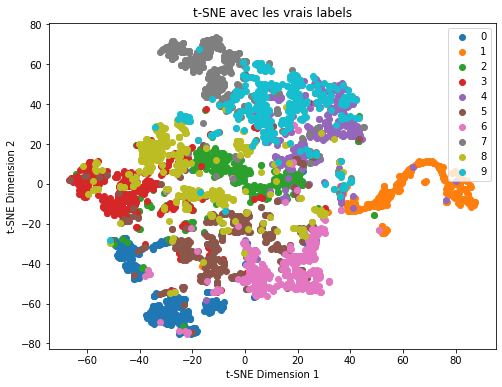

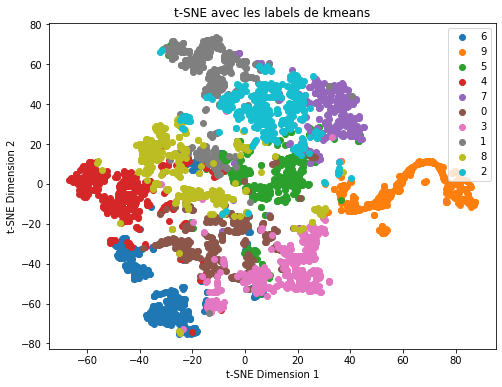

In [121]:
# Créer un graphique de dispersion en deux dimensions
plt.figure(figsize=(8, 6))
for cl in np.unique(Y_eq):
  icl = Y_eq==cl
  x_a,y_a = X_enc_eq_tsne[icl,0],X_enc_eq_tsne[icl,1]
  plt.scatter(x_a, y_a, label=cl)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE avec les vrais labels')
plt.legend()

plt.show()

# Créer un graphique de dispersion en deux dimensions
plt.figure(figsize=(8, 6))
for i in np.argsort(labels_max):
  cl = ind_clust[i]
  icl = kmeans_labels==cl
  x_a,y_a = X_enc_eq_tsne[icl,0],X_enc_eq_tsne[icl,1]
  plt.scatter(x_a, y_a, label=cl)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE avec les labels de kmeans')
plt.legend()

plt.show()

### Avec les données de test

In [126]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Initialiser et exécuter l'algorithme KMeans
nb_cl = len(np.unique(Y_test))

kmeans = KMeans(n_clusters=nb_cl, random_state=0, max_iter=1_000)
kmeans_labels = kmeans.fit_predict(X_test_enc_eq)


# Appliquer t-SNE pour réduire la dimensionnalité à deux dimensions
tsne = TSNE(n_components=2, random_state=0)
X_test_enc_eq_tsne = tsne.fit_transform(X_test_enc_eq)

/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


clust: 0
  cli:  0    2    3    4    5    6    8    
  ni :  174  10   5    2    12   11   7    


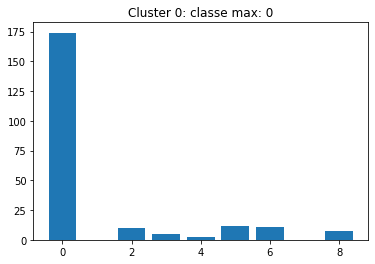

clust: 1
  cli:  0    2    3    4    5    6    7    8    9    
  ni :  5    147  4    37   12   9    6    7    1    


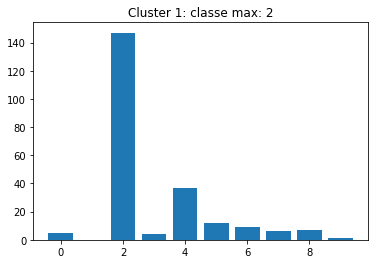

clust: 2
  cli:  1    4    9    
  ni :  218  1    7    


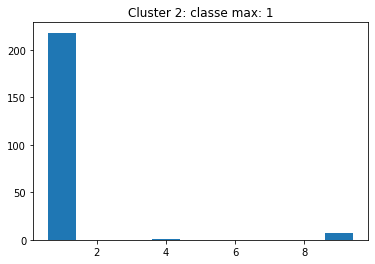

clust: 3
  cli:  0    2    3    5    8    
  ni :  3    25   187  14   21   


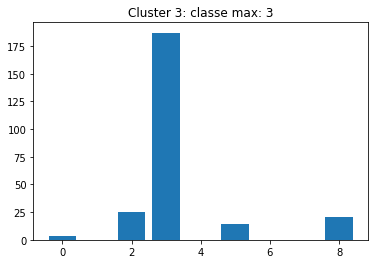

clust: 4
  cli:  0    2    3    7    8    9    
  ni :  1    22   3    168  6    23   


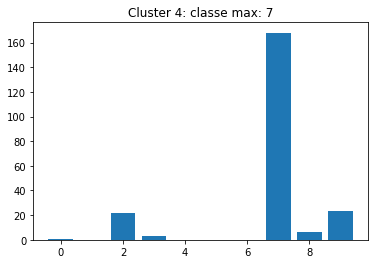

clust: 5
  cli:  0    2    3    4    5    7    8    9    
  ni :  3    3    1    119  2    12   3    52   


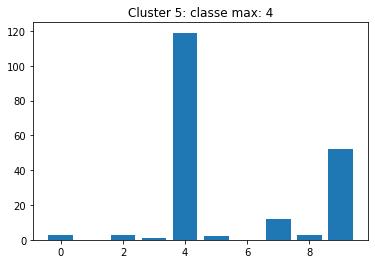

clust: 6
  cli:  0    2    4    5    6    8    
  ni :  27   2    4    27   175  2    


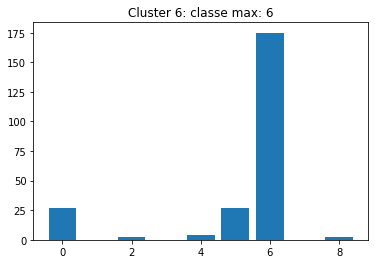

clust: 7
  cli:  0    2    3    4    5    6    7    8    9    
  ni :  11   6    15   2    148  17   3    4    1    


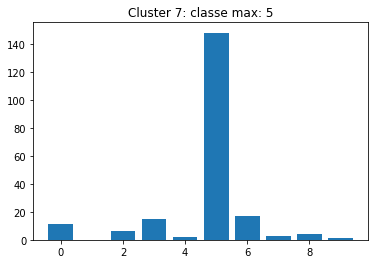

clust: 8
  cli:  2    3    4    5    6    7    8    9    
  ni :  3    1    52   4    3    35   10   138  


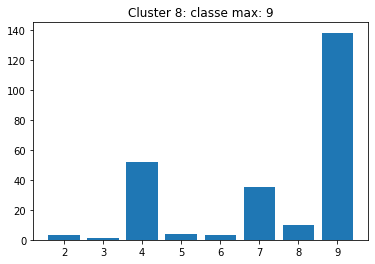

clust: 9
  cli:  1    2    3    4    5    6    8    9    
  ni :  6    6    8    7    5    9    164  2    


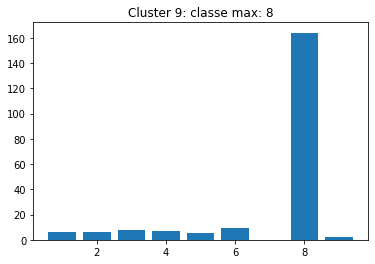

La classe maximale dans chaque cluster du kmeans:
  [0, 2, 1, 3, 7, 4, 6, 5, 9, 8]


In [127]:
labels_max = [] # classe la plus representée dans chaque cluster
ind_clust = []
for cl in np.unique(kmeans_labels):
  icl = kmeans_labels==cl
  Y_cl = Y_test_eq[icl]  # vrais labels des elts du clust cl
  cli,ni = np.unique(Y_cl,return_counts=True)
  
  cli_str,ni_str = "",""
  cli_str = cli_str.join(["{:<5}".format(str(clij)) for clij in cli])
  ni_str = ni_str.join(["{:<5}".format(str(nij)) for nij in ni])
  print(f"clust: {cl}\n  cli:  {cli_str}\n  ni :  {ni_str}")
  
  labels_max.append(cli[np.argmax(ni)])
  ind_clust.append(cl)

  plt.bar(cli,ni)
  plt.title(f"Cluster {cl}: classe max: {cli[np.argmax(ni)]}")
  plt.show()
print(f"La classe maximale dans chaque cluster du kmeans:\n  {labels_max}")


Les classes sont isolées. Chaque classe est maximale dans un cluster.

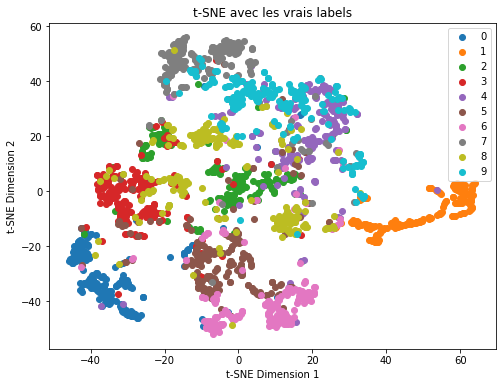

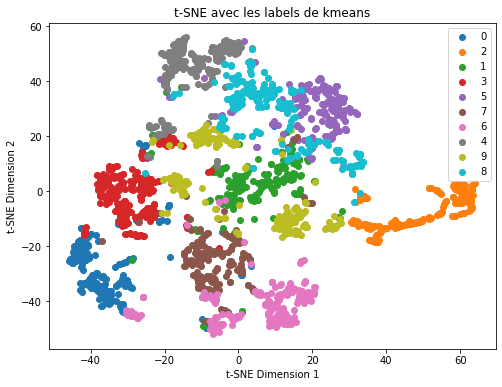

In [128]:
# Créer un graphique de dispersion en deux dimensions
plt.figure(figsize=(8, 6))
for cl in np.unique(Y_test_eq):
  icl = Y_test_eq==cl
  x_a,y_a = X_test_enc_eq_tsne[icl,0],X_test_enc_eq_tsne[icl,1]
  plt.scatter(x_a, y_a, label=cl)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE avec les vrais labels')
plt.legend()

plt.show()

# Créer un graphique de dispersion en deux dimensions
plt.figure(figsize=(8, 6))
for i in np.argsort(labels_max):
  cl = ind_clust[i]
  icl = kmeans_labels==cl
  x_a,y_a = X_test_enc_eq_tsne[icl,0],X_test_enc_eq_tsne[icl,1]
  plt.scatter(x_a, y_a, label=cl)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE avec les labels de kmeans')
plt.legend()

plt.show()

Nous voyons avec t-SNE que les classes sont plutôt très bien séparées avec le clustering du kmeans sur l'espace latent. Cela donne l'impression de super bien fonctionner.
</br>
Cependant nous voyons que certaines classes qui ne ressemblent comme:</br>
- classe 9: la quatre lui ressemble un peu beaucoup, la sept un peu quand même
- classe 8 est très bien isolée de toutes autres
- classe 6: la zero et cinq un peu, pas beaucoup
- classe 7: un peu à la deux et la neuf
- classe 1: très isolée de toutes les autres
- classe 6: très isolée de toutes les autres

Ce n'est pas parfait non plus !

## Etude des performances en classification en utilsant la représentation latente

### Avec la représentation originale

In [145]:
model_lin_1 = Modules.Linear(256,16)

model_tanh = Modules.TanH()

model_lin_2 = Modules.Linear(16,10)

model_sig = Modules.Sigmoid()

model_softmax = Modules.Softmax()

loss_fn = Loss.CELoss()

reseau_seq = Modules.Sequentiel((model_lin_1,
                                 model_tanh,
                                 model_lin_2,
                                 model_sig,
                                 model_softmax))

optim = Modules.Optim(reseau_seq,loss_fn,lr=1e-3)

In [146]:
l_train_loss = Modules.SGD(reseau_seq,loss_fn,(X,Y),batch_size=5,epochs=1_000,lr=1e-3)
pred_test = Modules.prediction(X_test,reseau_seq)
pred_train = Modules.prediction(X,reseau_seq)

correct_test = (pred_test == Y_test).sum() / len(Y_test)
correct_train = (pred_train == Y).sum() / len(Y)

print(f"Accuracy train: \n {(100*correct_train):>0.1f}")
print(f"Accuracy test: \n {(100*correct_test):>0.1f}")

# Accuracy train: 
#  80.9
# Accuracy test: 
#  76.8

Accuracy train: 
 80.9
Accuracy test: 
 76.8


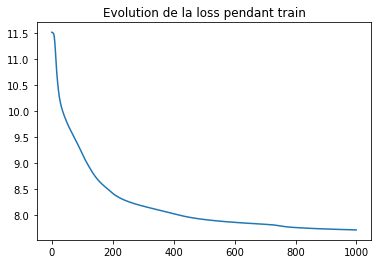

In [147]:
plt.figure()
plt.plot(np.arange(len(l_train_loss)),l_train_loss)
plt.title("Evolution de la loss pendant train")
plt.show()

### Avec la représentation latente

In [142]:
model_lin_1 = Modules.Linear(10,16)

model_tanh = Modules.TanH()
# model_tanh.ajouter_precendent(model_lin_1)
# model_lin_1.ajouter_suivant(model_tanh)

model_lin_2 = Modules.Linear(16,10)
# model_lin_2.ajouter_precendent(model_tanh)
# model_tanh.ajouter_suivant(model_lin_2)

model_sig = Modules.Sigmoid()
# model_sig.ajouter_precendent(model_lin_2)
# model_lin_2.ajouter_suivant(model_sig)

model_softmax = Modules.Softmax()
# model_softmax.ajouter_precendent(model_sig)
# model_sig.ajouter_suivant(model_softmax)

loss_fn = Loss.CELoss()

reseau_seq = Modules.Sequentiel((model_lin_1,
                                 model_tanh,
                                 model_lin_2,
                                 model_sig,
                                 model_softmax))

optim = Modules.Optim(reseau_seq,loss_fn,lr=1e-3)

In [143]:
l_train_loss = Modules.SGD(reseau_seq,loss_fn,(X_enc,Y),batch_size=5,epochs=1_000,lr=1e-3)
pred_test = Modules.prediction(X_test_enc,reseau_seq)
pred_train = Modules.prediction(X_enc,reseau_seq)

correct_test = (pred_test == Y_test).sum() / len(Y_test)
correct_train = (pred_train == Y).sum() / len(Y)

print(f"Accuracy train: \n {(100*correct_train):>0.1f}")
print(f"Accuracy test: \n {(100*correct_test):>0.1f}")

# Accuracy train: 
#  73.3
# Accuracy test: 
#  71.2

Accuracy train: 
 73.3
Accuracy test: 
 71.2


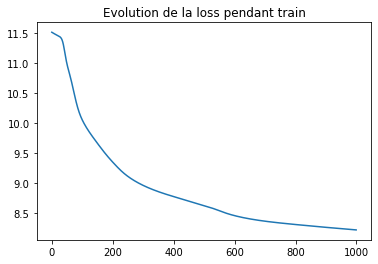

In [144]:
plt.figure()
plt.plot(np.arange(len(l_train_loss)),l_train_loss)
plt.title("Evolution de la loss pendant train")
plt.show()

La grosse remarque est que l'apprentissage du réseau de neuronnes tourne plus vite avec la représentation latente. Se serait intéressant si on veut apprendre un modèle vite fait et que l'encodage ne couterait pas cher.</br>
Par contre sur le même nombre d'itération(epochs), le réseau avec la représentation de départ semble convergé plus rapidement que celui avec la représentation latente.</br>
Si l'on pouvait donner un chrono à l'algo d'apprentissage, cependant j'ai l'intuition que celui avec la représentation latente donnerait de meilleurs résultat. C'est possible de bidouiller pour faire une vérification mais faisons confiance à notre intuition.

## Etude des performances en débruitage

### Ajout d'un bruit Gaussian aux données originales

In [5]:
# Ajouter du bruit gaussien à la matrice X
noise = np.random.randn(*X.shape) * 0.1
g_X = X + noise

noise_test = np.random.randn(*X_test.shape) * 0.1
g_X_test = X_test + noise_test

In [6]:
enc_lin_1 = Modules.Linear(256,100)
enc_tanh_1 = Modules.TanH()
enc_lin_2 = Modules.Linear(100,10)
enc_tanh_2 = Modules.TanH()

dec_lin_1 = Modules.Linear(10,100)
dec_tanh = Modules.TanH()
dec_lin_2 = Modules.Linear(100,256)
dec_sig = Modules.Sigmoid()

res_enc = [(enc_lin_1,dec_lin_2),(enc_tanh_1,),(enc_lin_2,dec_lin_1),(enc_tanh_2,)]
res_dec = [(dec_lin_1,enc_lin_2),(dec_tanh,),(dec_lin_2,enc_lin_1),(dec_sig,)]

loss_fn = Loss.BELoss()

enc_dec = Modules.EncDec(res_enc,res_dec)

optim = Modules.Optim(enc_dec,loss_fn,lr=1e-3)

In [7]:
l_train_loss = Modules.SGD(enc_dec,loss_fn,(g_X,X),batch_size=5,epochs=1_000,lr=1e-3)

g_X_test_dec = enc_dec.forward(g_X_test)
g_X_dec      = enc_dec.forward(g_X)

g_X_test_enc = enc_dec.encoder(g_X_test)
g_X_enc = enc_dec.encoder(g_X)

In [8]:
X_test_dec = enc_dec.forward(X_test)
X_dec      = enc_dec.forward(X)

X_test_enc = enc_dec.encoder(X_test)
X_enc = enc_dec.encoder(X)

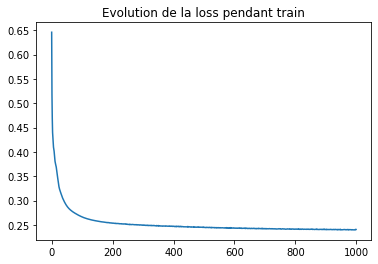

In [9]:
plt.figure()
plt.plot(np.arange(len(l_train_loss)),l_train_loss)
plt.title("Evolution de la loss pendant train")
plt.show()

#### Visualisation des images débruitées reconstruites après une forte compression

Avec les données bruitées d'entrainement

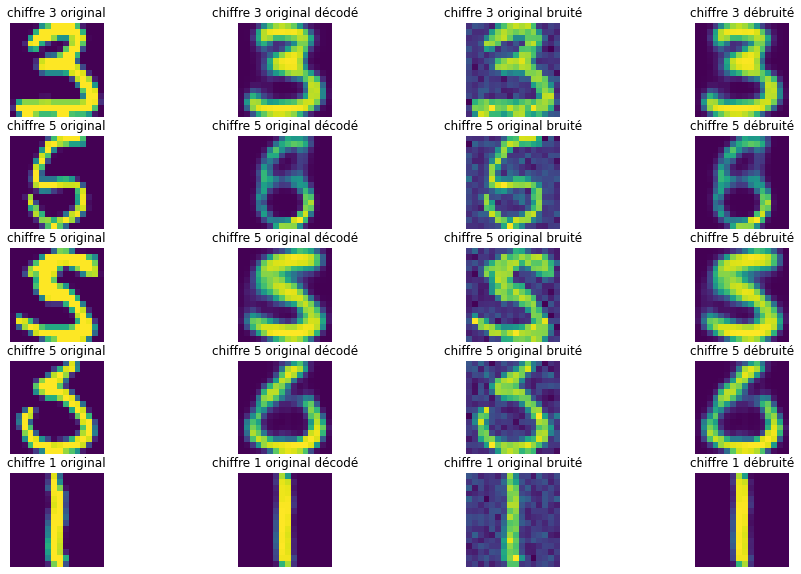

In [13]:
k = 5
indices = np.random.choice(np.arange(len(Y)),k)

fig, axes = plt.subplots(k, 4, figsize=(2*8, 2*k))
isub = 0
for i,ind in enumerate(indices):
  # sans bruit
  axes[i, 0].imshow(X[ind].reshape((16,16)))
  axes[i, 0].set_title(f"chiffre {Y[ind]} original")
  
  axes[i, 1].imshow(g_X_dec[ind].reshape((16,16)))
  axes[i, 1].set_title(f"chiffre {Y[ind]} original décodé")
  
  # avec du bruit
  axes[i, 2].imshow(g_X[ind].reshape((16,16)))
  axes[i, 2].set_title(f"chiffre {Y[ind]} original bruité")
  
  axes[i, 3].imshow(g_X_dec[ind].reshape((16,16)))
  axes[i, 3].set_title(f"chiffre {Y[ind]} débruité")

# Masquer les axes sur lesquels les images sont affichées
for ax in axes.flat:
  ax.axis('off')

# Ajuster les espaces entre les subplots
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

Avec les données bruitées de test

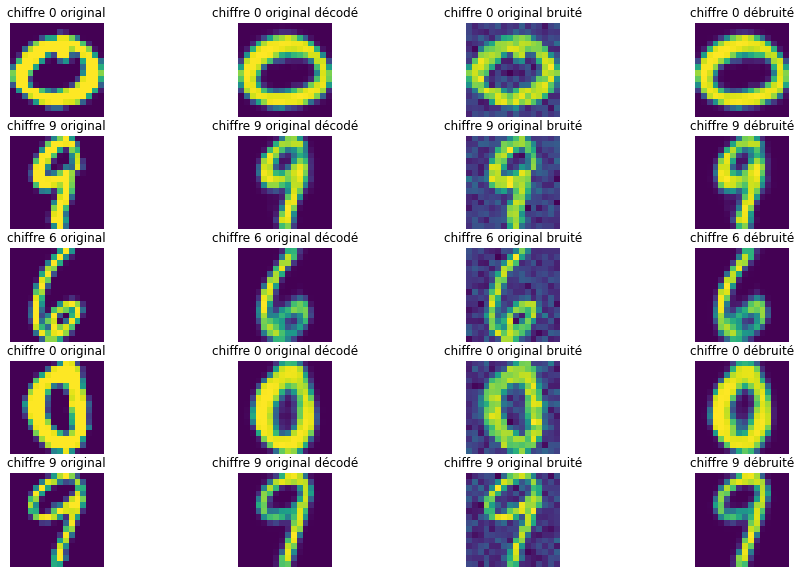

In [14]:
k = 5
indices = np.random.choice(np.arange(len(Y_test)),k)

fig, axes = plt.subplots(k, 4, figsize=(2*8, 2*k))
isub = 0
for i,ind in enumerate(indices):
  # sans bruit
  axes[i, 0].imshow(X_test[ind].reshape((16,16)))
  axes[i, 0].set_title(f"chiffre {Y_test[ind]} original")
  
  axes[i, 1].imshow(X_test_dec[ind].reshape((16,16)))
  axes[i, 1].set_title(f"chiffre {Y_test[ind]} original décodé")
  
  # avec du bruit
  axes[i, 2].imshow(g_X_test[ind].reshape((16,16)))
  axes[i, 2].set_title(f"chiffre {Y_test[ind]} original bruité")
  
  axes[i, 3].imshow(g_X_test_dec[ind].reshape((16,16)))
  axes[i, 3].set_title(f"chiffre {Y_test[ind]} débruité")

# Masquer les axes sur lesquels les images sont affichées
for ax in axes.flat:
  ax.axis('off')

# Ajuster les espaces entre les subplots
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

Nous remarquons que l'apprentissage avec des données bruitées améliore les performances.

#### Visualisation des représentations obtenues dans un espaces 2D avec t-sne

On équilibre les classes vu que kmeans et t-SNE y sont sensibles

In [21]:
# on équilibre les classes vu que t-SNE et kmeans y sont sensibles
inds_eq = Modules.equilibrer_classes(Y)
inds_test_eq = Modules.equilibrer_classes(Y_test)
print(f"dimension de départ: {len(Y)}\ndimension equilibrée: {len(inds_eq)}")

# equilibrage des données originales
X_eq,Y_eq = X[inds_eq],Y[inds_eq]
X_test_eq,Y_test_eq = X_test[inds_test_eq],Y_test[inds_test_eq]

# équilibrage des données encodées
X_enc_eq = X_enc[inds_eq]
X_test_enc_eq = X_test_enc[inds_test_eq]
# équilibrage des données décodées
X_dec_eq = X_dec[inds_eq]
X_test_dec_eq = X_test_dec[inds_test_eq]

# avec bruit
g_X_eq      = g_X[inds_eq]
g_X_test_eq = g_X_test[inds_test_eq]

g_X_dec_eq      = g_X_dec[inds_eq]
g_X_test_dec_eq = g_X_test_dec[inds_test_eq]

g_X_enc_eq = g_X_enc[inds_eq]
g_X_test_enc_eq = g_X_test_enc[inds_test_eq]


dimension de départ: 6229
dimension equilibrée: 4720


#### t-SNE sur les données train

Données originales

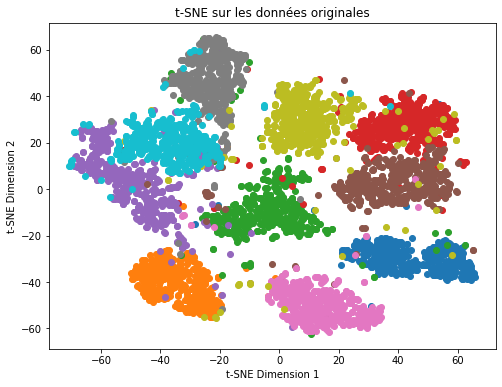

In [18]:
from sklearn.manifold import TSNE

# Appliquer t-SNE pour réduire la dimensionnalité à deux dimensions
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X_eq)

# Créer un graphique de dispersion en deux dimensions
plt.figure(figsize=(8, 6))
for cl in np.unique(Y_eq):
  icl = Y_eq==cl
  x_a,y_a = X_tsne[icl,0],X_tsne[icl,1]
  plt.scatter(x_a, y_a, label=cl)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE sur les données originales')

plt.show()

Données originales bruitées

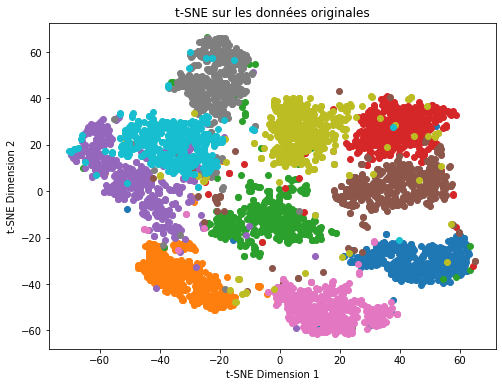

In [22]:
from sklearn.manifold import TSNE

# Appliquer t-SNE pour réduire la dimensionnalité à deux dimensions
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(g_X_eq)

# Créer un graphique de dispersion en deux dimensions
plt.figure(figsize=(8, 6))
for cl in np.unique(Y_eq):
  icl = Y_eq==cl
  x_a,y_a = X_tsne[icl,0],X_tsne[icl,1]
  plt.scatter(x_a, y_a, label=cl)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE sur les données originales')

plt.show()

Données originales encodées

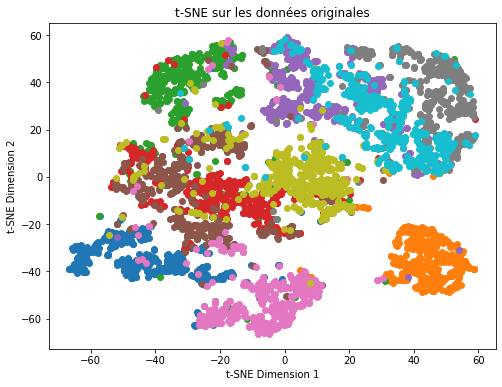

In [23]:
from sklearn.manifold import TSNE

# Appliquer t-SNE pour réduire la dimensionnalité à deux dimensions
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X_enc_eq)

# Créer un graphique de dispersion en deux dimensions
plt.figure(figsize=(8, 6))
for cl in np.unique(Y_eq):
  icl = Y_eq==cl
  x_a,y_a = X_tsne[icl,0],X_tsne[icl,1]
  plt.scatter(x_a, y_a, label=cl)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE sur les données originales')

plt.show()

Données bruitées encodées

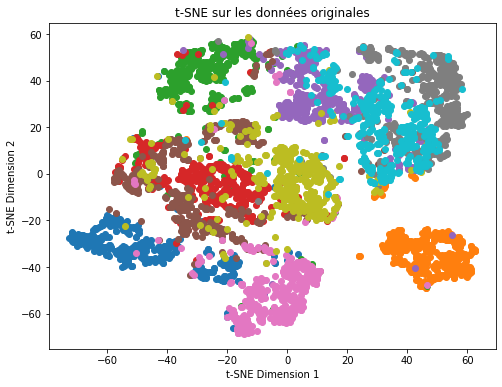

In [24]:
from sklearn.manifold import TSNE

# Appliquer t-SNE pour réduire la dimensionnalité à deux dimensions
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(g_X_enc_eq)

# Créer un graphique de dispersion en deux dimensions
plt.figure(figsize=(8, 6))
for cl in np.unique(Y_eq):
  icl = Y_eq==cl
  x_a,y_a = X_tsne[icl,0],X_tsne[icl,1]
  plt.scatter(x_a, y_a, label=cl)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE sur les données originales')

plt.show()

Données originales décodées

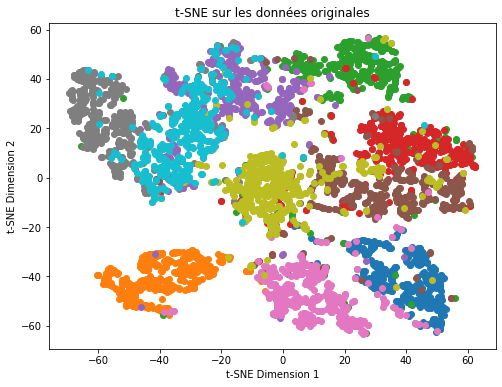

In [25]:
from sklearn.manifold import TSNE

# Appliquer t-SNE pour réduire la dimensionnalité à deux dimensions
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X_dec_eq)

# Créer un graphique de dispersion en deux dimensions
plt.figure(figsize=(8, 6))
for cl in np.unique(Y_eq):
  icl = Y_eq==cl
  x_a,y_a = X_tsne[icl,0],X_tsne[icl,1]
  plt.scatter(x_a, y_a, label=cl)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE sur les données originales')

plt.show()

Données bruitées décodées

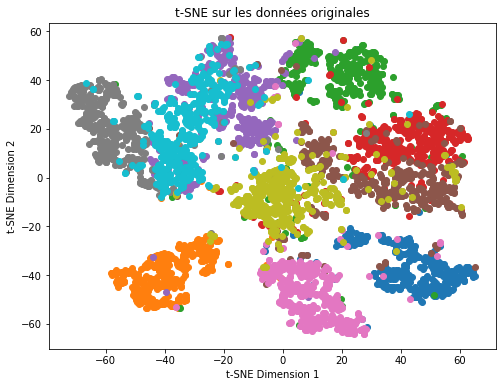

In [26]:
from sklearn.manifold import TSNE

# Appliquer t-SNE pour réduire la dimensionnalité à deux dimensions
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(g_X_dec_eq)

# Créer un graphique de dispersion en deux dimensions
plt.figure(figsize=(8, 6))
for cl in np.unique(Y_eq):
  icl = Y_eq==cl
  x_a,y_a = X_tsne[icl,0],X_tsne[icl,1]
  plt.scatter(x_a, y_a, label=cl)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE sur les données originales')

plt.show()

#### t-SNE sur les données test

Données originales de test

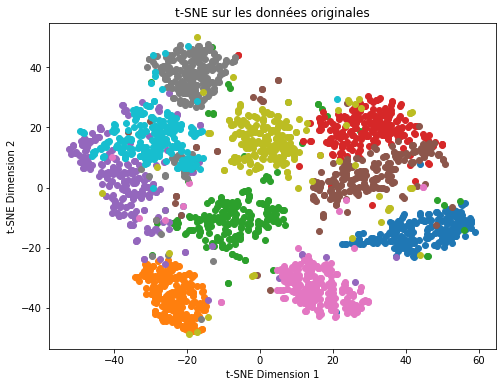

In [28]:
from sklearn.manifold import TSNE

# Appliquer t-SNE pour réduire la dimensionnalité à deux dimensions
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X_test_eq)

# Créer un graphique de dispersion en deux dimensions
plt.figure(figsize=(8, 6))
for cl in np.unique(Y_test_eq):
  icl = Y_test_eq==cl
  x_a,y_a = X_tsne[icl,0],X_tsne[icl,1]
  plt.scatter(x_a, y_a, label=cl)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE sur les données originales')

plt.show()

Données originales de test bruitées

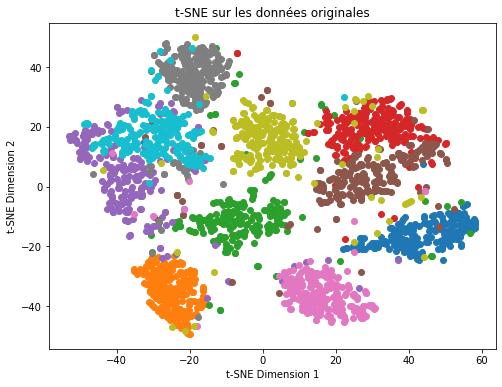

In [29]:
from sklearn.manifold import TSNE

# Appliquer t-SNE pour réduire la dimensionnalité à deux dimensions
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(g_X_test_eq)

# Créer un graphique de dispersion en deux dimensions
plt.figure(figsize=(8, 6))
for cl in np.unique(Y_test_eq):
  icl = Y_test_eq==cl
  x_a,y_a = X_tsne[icl,0],X_tsne[icl,1]
  plt.scatter(x_a, y_a, label=cl)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE sur les données originales')

plt.show()

Données originales de test encodées

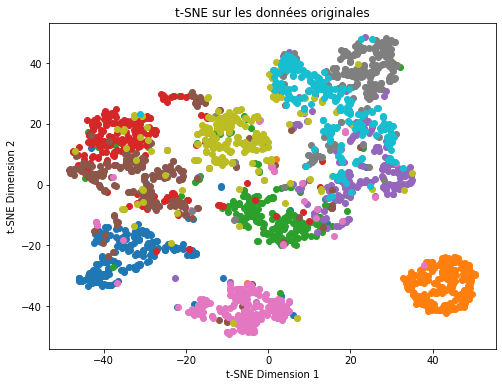

In [30]:
from sklearn.manifold import TSNE

# Appliquer t-SNE pour réduire la dimensionnalité à deux dimensions
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X_test_enc_eq)

# Créer un graphique de dispersion en deux dimensions
plt.figure(figsize=(8, 6))
for cl in np.unique(Y_test_eq):
  icl = Y_test_eq==cl
  x_a,y_a = X_tsne[icl,0],X_tsne[icl,1]
  plt.scatter(x_a, y_a, label=cl)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE sur les données originales')

plt.show()

Données bruitées de test encodées

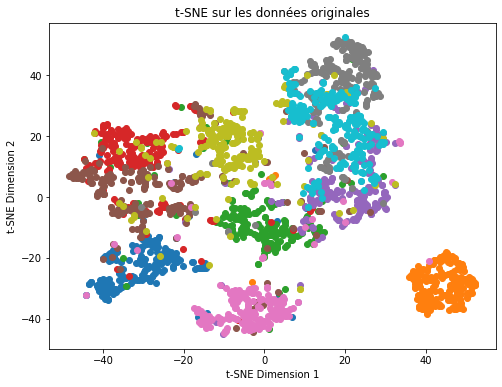

In [31]:
from sklearn.manifold import TSNE

# Appliquer t-SNE pour réduire la dimensionnalité à deux dimensions
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(g_X_test_enc_eq)

# Créer un graphique de dispersion en deux dimensions
plt.figure(figsize=(8, 6))
for cl in np.unique(Y_test_eq):
  icl = Y_test_eq==cl
  x_a,y_a = X_tsne[icl,0],X_tsne[icl,1]
  plt.scatter(x_a, y_a, label=cl)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE sur les données originales')

plt.show()

Données originales de test décodées

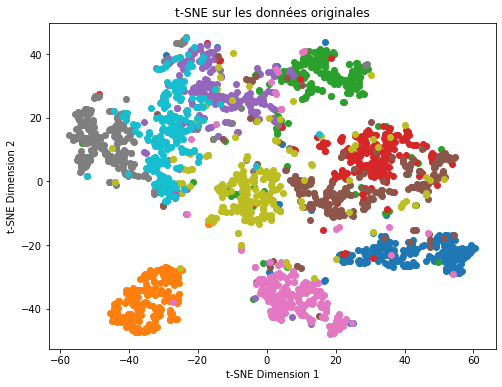

In [32]:
from sklearn.manifold import TSNE

# Appliquer t-SNE pour réduire la dimensionnalité à deux dimensions
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X_test_dec_eq)

# Créer un graphique de dispersion en deux dimensions
plt.figure(figsize=(8, 6))
for cl in np.unique(Y_test_eq):
  icl = Y_test_eq==cl
  x_a,y_a = X_tsne[icl,0],X_tsne[icl,1]
  plt.scatter(x_a, y_a, label=cl)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE sur les données originales')

plt.show()

Données bruitées de test décodées

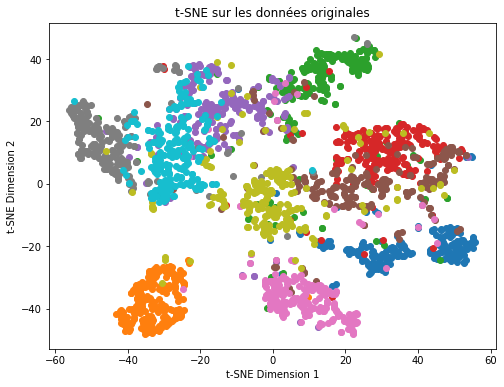

In [33]:
from sklearn.manifold import TSNE

# Appliquer t-SNE pour réduire la dimensionnalité à deux dimensions
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(g_X_test_dec_eq)

# Créer un graphique de dispersion en deux dimensions
plt.figure(figsize=(8, 6))
for cl in np.unique(Y_test_eq):
  icl = Y_test_eq==cl
  x_a,y_a = X_tsne[icl,0],X_tsne[icl,1]
  plt.scatter(x_a, y_a, label=cl)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE sur les données originales')

plt.show()

Nous remarquons que les données sont également mieux séparées avec l'apprentissage avec du bruit.

### Etude du clustering induit dans l'espace latent avec l'apprentissage bruité

#### avec les données d'entrainement (train)

In [34]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Initialiser et exécuter l'algorithme KMeans
nb_cl = len(np.unique(Y))

kmeans = KMeans(n_clusters=nb_cl, random_state=0, max_iter=1_000)
kmeans_labels = kmeans.fit_predict(X_enc_eq)


# Appliquer t-SNE pour réduire la dimensionnalité à deux dimensions
tsne = TSNE(n_components=2, random_state=0)
X_enc_eq_tsne = tsne.fit_transform(X_enc_eq)

/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


clust: 0
  cli:  0    2    3    4    5    7    8    9    
  ni :  1    3    7    37   8    315  1    87   


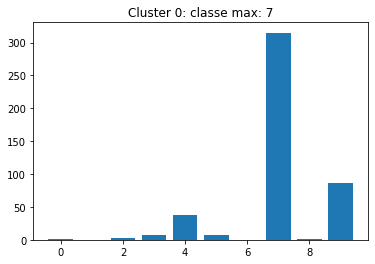

clust: 1
  cli:  0    1    2    3    4    5    6    7    8    9    
  ni :  2    1    34   4    305  42   4    18   17   82   


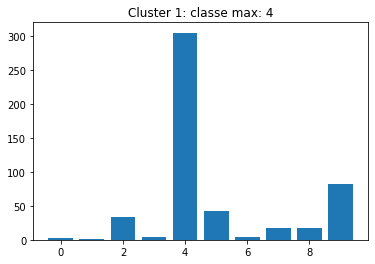

clust: 2
  cli:  0    2    3    5    6    7    8    9    
  ni :  16   16   380  280  4    1    47   2    


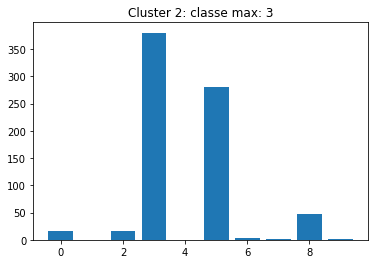

clust: 3
  cli:  0    1    2    3    4    5    6    8    
  ni :  68   6    3    2    10   19   371  3    


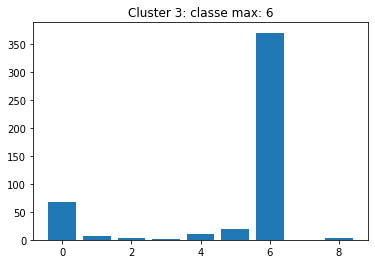

clust: 4
  cli:  1    2    4    6    
  ni :  444  1    2    3    


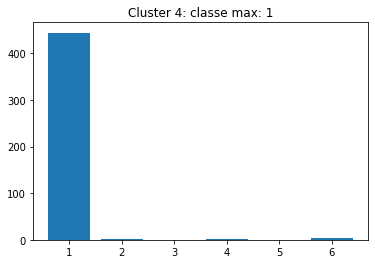

clust: 5
  cli:  0    1    2    3    4    5    6    7    8    
  ni :  4    1    367  17   9    10   7    3    14   


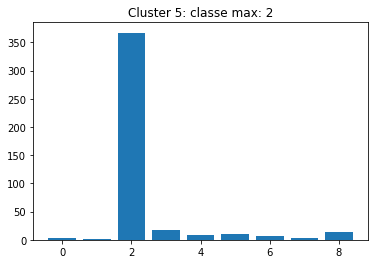

clust: 6
  cli:  0    2    3    5    6    8    9    
  ni :  175  4    7    37   63   2    2    


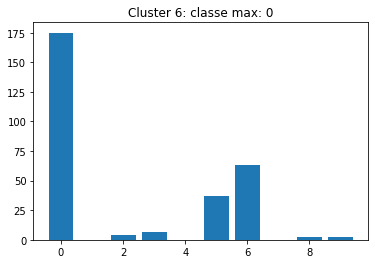

clust: 7
  cli:  1    2    3    4    5    6    7    8    9    
  ni :  16   2    8    104  10   2    131  37   295  


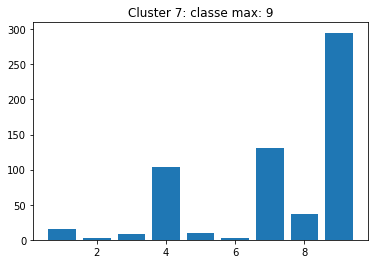

clust: 8
  cli:  0    2    3    4    5    6    7    8    
  ni :  202  1    4    1    18   15   1    4    


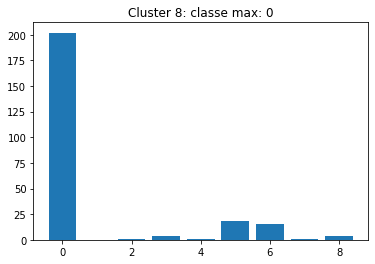

clust: 9
  cli:  0    1    2    3    4    5    6    7    8    9    
  ni :  4    4    41   43   4    48   3    3    347  4    


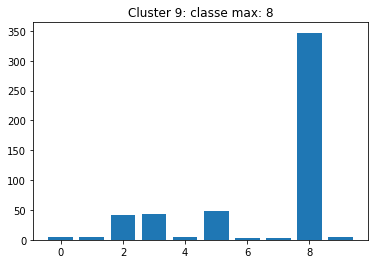

La classe maximale dans chaque cluster du kmeans:
  [7, 4, 3, 6, 1, 2, 0, 9, 0, 8]


In [35]:
labels_max = [] # classe la plus representée dans chaque cluster
ind_clust = []
for cl in np.unique(kmeans_labels):
  icl = kmeans_labels==cl
  Y_cl = Y_eq[icl]  # vrais labels des elts du clust cl
  cli,ni = np.unique(Y_cl,return_counts=True)
  cli_str,ni_str = "",""
  cli_str = cli_str.join(["{:<5}".format(str(clij)) for clij in cli])
  ni_str = ni_str.join(["{:<5}".format(str(nij)) for nij in ni])
  print(f"clust: {cl}\n  cli:  {cli_str}\n  ni :  {ni_str}")
  labels_max.append(cli[np.argmax(ni)])
  ind_clust.append(cl)

  plt.bar(cli,ni)
  plt.title(f"Cluster {cl}: classe max: {cli[np.argmax(ni)]}")
  plt.show()
print(f"La classe maximale dans chaque cluster du kmeans:\n  {labels_max}")


Cette fois la classe 5 s'est éparpiée du coup ne s'est pas isolées.

In [38]:
labels_max_b = [c for c in labels_max]
labels_max_b[-2] = 5
labels_max_b

[7, 4, 3, 6, 1, 2, 0, 9, 5, 8]

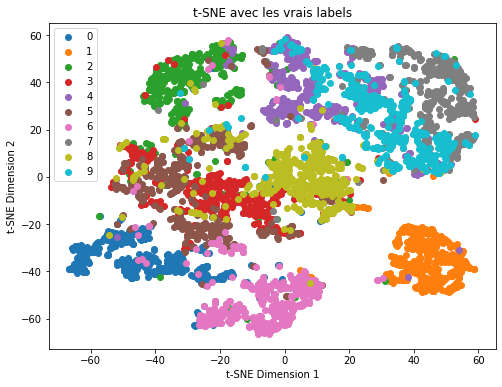

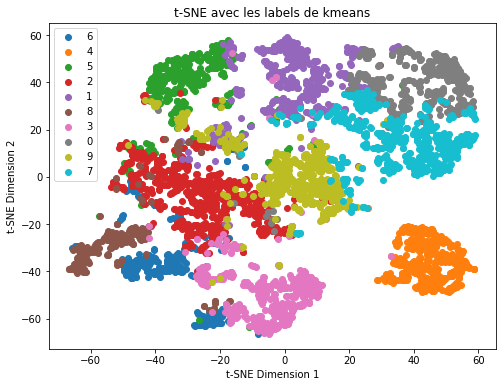

In [40]:
# Créer un graphique de dispersion en deux dimensions
plt.figure(figsize=(8, 6))
for cl in np.unique(Y_eq):
  icl = Y_eq==cl
  x_a,y_a = X_enc_eq_tsne[icl,0],X_enc_eq_tsne[icl,1]
  plt.scatter(x_a, y_a, label=cl)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE avec les vrais labels')
plt.legend()

plt.show()

# Créer un graphique de dispersion en deux dimensions
plt.figure(figsize=(8, 6))
for i in np.argsort(labels_max_b):
  cl = ind_clust[i]
  icl = kmeans_labels==cl
  x_a,y_a = X_enc_eq_tsne[icl,0],X_enc_eq_tsne[icl,1]
  plt.scatter(x_a, y_a, label=cl)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE avec les labels de kmeans')
plt.legend()

plt.show()

#### avec les données bruitées

In [41]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Initialiser et exécuter l'algorithme KMeans
nb_cl = len(np.unique(Y))

kmeans = KMeans(n_clusters=nb_cl, random_state=0, max_iter=1_000)
kmeans_labels = kmeans.fit_predict(g_X_enc_eq)


# Appliquer t-SNE pour réduire la dimensionnalité à deux dimensions
tsne = TSNE(n_components=2, random_state=0)
X_enc_eq_tsne = tsne.fit_transform(X_enc_eq)

/usr/local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


clust: 0
  cli:  1    2    3    4    5    7    8    9    
  ni :  20   1    1    91   13   137  34   291  


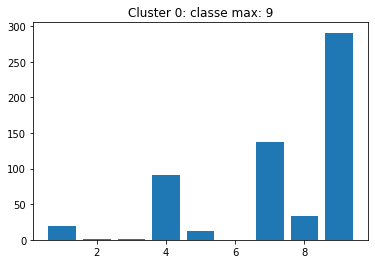

clust: 1
  cli:  0    1    2    3    4    5    6    7    8    9    
  ni :  6    4    37   39   2    16   4    5    334  3    


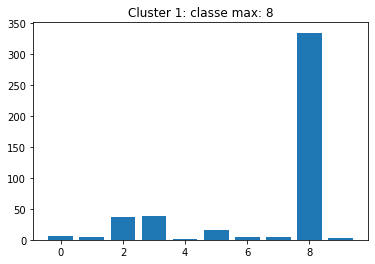

clust: 2
  cli:  0    2    3    5    6    8    
  ni :  331  4    6    9    69   3    


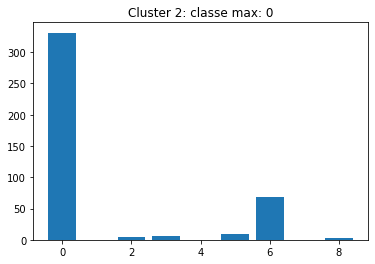

clust: 3
  cli:  0    2    3    4    5    6    7    8    9    
  ni :  2    20   1    316  14   3    28   12   102  


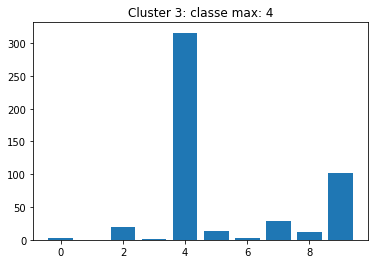

clust: 4
  cli:  1    2    4    6    
  ni :  443  1    2    1    


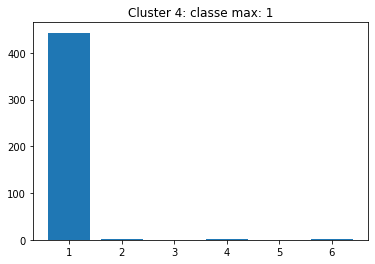

clust: 5
  cli:  0    1    2    3    4    5    6    8    
  ni :  40   3    4    2    17   15   379  4    


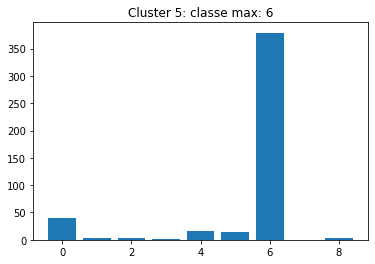

clust: 6
  cli:  0    2    3    4    5    6    7    8    9    
  ni :  1    23   83   6    221  2    5    32   6    


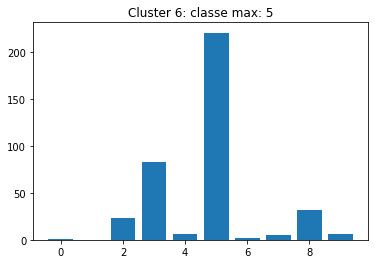

clust: 7
  cli:  0    1    2    3    4    5    6    7    8    9    
  ni :  2    1    363  9    18   3    7    2    16   1    


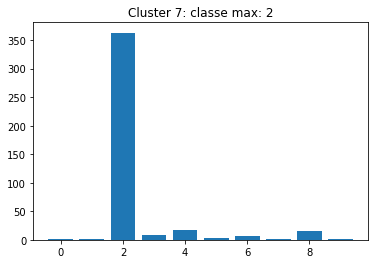

clust: 8
  cli:  0    2    3    4    5    7    8    9    
  ni :  1    2    2    20   5    295  1    67   


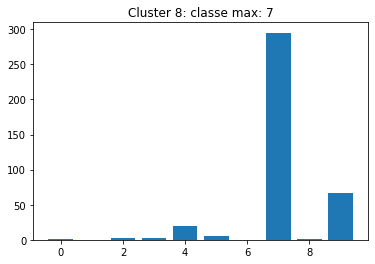

clust: 9
  cli:  0    1    2    3    5    6    8    9    
  ni :  89   1    17   329  176  7    36   2    


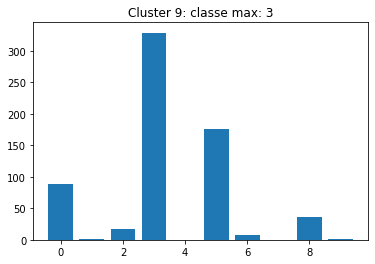

La classe maximale dans chaque cluster du kmeans:
  [9, 8, 0, 4, 1, 6, 5, 2, 7, 3]


In [42]:
labels_max = [] # classe la plus representée dans chaque cluster
ind_clust = []
for cl in np.unique(kmeans_labels):
  icl = kmeans_labels==cl
  Y_cl = Y_eq[icl]  # vrais labels des elts du clust cl
  cli,ni = np.unique(Y_cl,return_counts=True)
  cli_str,ni_str = "",""
  cli_str = cli_str.join(["{:<5}".format(str(clij)) for clij in cli])
  ni_str = ni_str.join(["{:<5}".format(str(nij)) for nij in ni])
  print(f"clust: {cl}\n  cli:  {cli_str}\n  ni :  {ni_str}")
  labels_max.append(cli[np.argmax(ni)])
  ind_clust.append(cl)

  plt.bar(cli,ni)
  plt.title(f"Cluster {cl}: classe max: {cli[np.argmax(ni)]}")
  plt.show()
print(f"La classe maximale dans chaque cluster du kmeans:\n  {labels_max}")


Avec les données bruitées toutes les classes sont bien isolées.

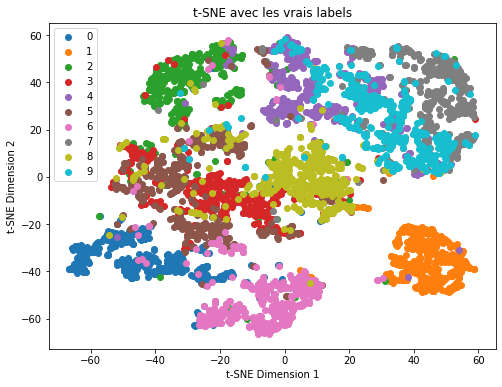

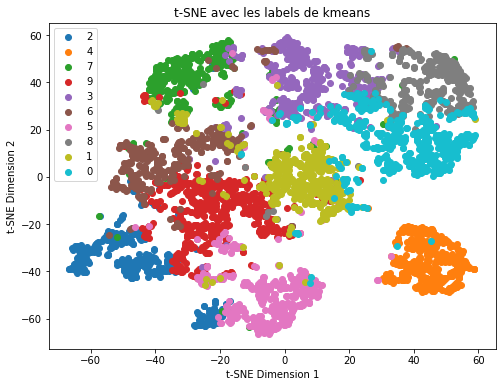

In [44]:
# Créer un graphique de dispersion en deux dimensions
plt.figure(figsize=(8, 6))
for cl in np.unique(Y_eq):
  icl = Y_eq==cl
  x_a,y_a = X_enc_eq_tsne[icl,0],X_enc_eq_tsne[icl,1]
  plt.scatter(x_a, y_a, label=cl)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE avec les vrais labels')
plt.legend()

plt.show()

# Créer un graphique de dispersion en deux dimensions
plt.figure(figsize=(8, 6))
for i in np.argsort(labels_max):
  cl = ind_clust[i]
  icl = kmeans_labels==cl
  x_a,y_a = X_enc_eq_tsne[icl,0],X_enc_eq_tsne[icl,1]
  plt.scatter(x_a, y_a, label=cl)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE avec les labels de kmeans')
plt.legend()

plt.show()